## TPC3

Pretendemos simular a propagação de ondas sísmicas, na situação simplificada de 1D. A equação de propagação da componente $y$ do deslocamento, $u_y(x,t)$, num meio com densidade $\rho(x)$ e constante elástica $\mu(x)$ é:
$$\rho(x) \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial}{\partial x} \bigg( \mu(x) \frac{\partial u_y}{\partial x}\bigg) + f_y,$$

onde $f_y(x,t)$ é uma força exteriormente aplicada (algo que dá origem a um sismo, como um deslocamento de placas, ou um desmoronamento sub-aquático). Use um método pseudo-espectral à sua escolha. Deve referir a razão da escolha, comparando com outro(s).
Para a força, use a função `ricke`, que se encontra no Moodle, com $f_0$ como frequência central. Como parâmetros use:

| Stretch/Untouched | ProbDistribution |
| :- | :-: |
| $\rho$ | $2500\ kg m^{-3}$ |
| $\mu$  | $2.25 \times 10^{10} kg  m^{-1}s^{-2}$ |
| $f_0$  | $100\ kHz$ |

Como é evidente, deve re-escalar a equação.

Considere condições fronteira de Dirichelet.

Deve submeter, além do código, um pequeno filme, ou conjunto de plots sequenciais, da evolução da perturbação inicial para o caso da alínea (e). Em cada imagem (plot) deve mostrar o tempo e indicar as quantidades representadas.

Cada um deve apresentar apenas trabalho seu. Podem usar as rotinas que coloquei no Moodle, ou outras equivalentes que tenham desenvolvido, mesmo que baseados nalguma fonte (mas devem claramente identificar essa fonte(s)).

a) Escolha um esquema para descretizar a derivada temporal, indicando também que método pretende usar para a evolução temporal. Discuta as vantagens e desvantagens desse método.

Partimos da equação

$$\rho(x) \frac{\partial^2 u_y}{\partial t^2} = \frac{\partial}{\partial x} \bigg( \mu(x) \frac{\partial u_y}{\partial x}\bigg) + f_y,$$

Vamos usar um operador de diferença centrais de 3 pontos, para aproximar as derivadas no tempo. Desse modo, o campo é extrapolado como:

$$
\rho_i\frac{u_{i}^{j+1} - 2u_{i}^{j} + u_{i}^{j-1}}{dt^2}= \frac{\partial}{\partial x}\bigg(\mu(x) \frac{\partial u_y}{\partial x}\bigg)_{i}^{j} + f_{i}^{j}
$$

Para a extrapolação temporal será usado o metodo explicito.

b) Use a rotina `ricker` (ler com cuidado a sua descrição, em particular os argumentos que pede e o respectivo uso, bem como a forma do resultado), de modo a gerar o termo fonte à frequência pretendida.

In [1]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
from ricker import ricker

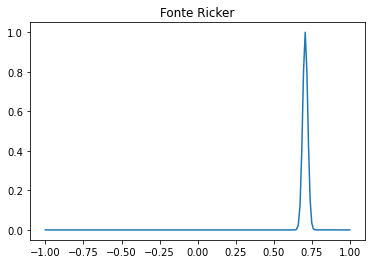

In [2]:
def fonte(rho, mu, f0, nx, tmax):
    '''Função para o termo fonte'''
    
    eps   = 1.4       # Limite de estabilidade
    isx   = 200
    lw    = 0.7
    ft    = 10

    # Velocidade de propagação
    c   = np.sqrt(mu/rho)
    
    xs = np.floor(nx/4)      # Inicio termo fonte
    xr = np.floor(nx*0.8)
    x  = np.zeros(nx+1) 
    
    x[:] = np.cos(np.arange(0,nx+1)*np.pi/nx)

    dxmin = min(abs(np.diff(x)))
    dxmax = max(abs(np.diff(x)))
    
    
    dt = eps*dxmin/c  # Calcular dt
    nt = int(round(tmax/np.max(dt)))

    # Função fonte no tempo
    # ---------------------------------------------------------------
    t = np.arange(1, nt+1)*np.max(dt)  
    T0 = 1./f0
    tmp = ricker(np.max(dt), T0) ## Termo fonte
    isrc = tmp
    tmp = np.diff(tmp)
    src = np.zeros(nt) 
    src[0:np.size(tmp)] = tmp
    
    # Função fonte espacial
    # ---------------------------------------------------------------
    sigma = 1.5*dxmax
    x0 = x[int(xs)]
    sg = np.exp(-1/sigma**2*(x-x0)**2)
    sg = sg/max(sg)

    
    return src,sg, dxmax, nt, dt, x


rho=2500.
mu=2.25*10**10 
f0=100000
nx=200
tmax=0.001
src,sg, dxmax, nt, dt,x =  fonte(rho,mu,f0,nx,tmax)

plt.figure(figsize=(6,4))
plt.plot(x,sg)
plt.title('Fonte Ricker')
plt.show()

c) Use um método espectral à sua escolha para discretizar as derivadas espaciais. Discuta os méritos e deméritos do método escolhido. Implemente um código que realize esta discretização.

Escolhemos o método de chebyshev com matriz de diferenciação e grid de chebyshev. Como vimos nas aulas a interpolação polinomial nos pontos de Chebyshev possuí performance superior ao caso de pontos equi-espaçados. Para além disso o método possuí boa estabilidade númerica e eficiencia computacional.

Para as derivadas espaciais define-se a matriz $D_{ij}$

$$
D_{ij} =
  \begin{cases}
    -\frac{2 N^2 + 1}{6} \hspace{1.5cm} \text{for  i  = j = N}\\
    -\frac{1}{2} \frac{x_i}{1-x_i^2} \hspace{1.5cm} \text{for i = j = 1,2,...,N-1}\\
    \frac{c_i}{c_j} \frac{(-1)^{i+j}}{x_i - x_j} \hspace{1.5cm} \text{for i $\neq$ j = 0,1,...,N}
  \end{cases}
$$

onde $N+1$ é o número de pontos Chebyshev $ \ x_i = cos(i\pi / N)$, $ \ i=0,...,N$ e $c_i$ é dado por

$$ c_i = 2 \hspace{1.5cm} \text{for  i  = 0 or N} $$
$$ c_i = 1 \hspace{1.5cm} \text{otherwise} $$


Essa matriz de diferenciação nos permite escrever a derivativa da função $f_i = f(x_i)$ como:


$$\partial_x u_i = D_{ij} \ u_j$$


onde o lado direito é um produto matriz-vector.

In [3]:

def cheb(N):
    '''compute D = differentiation matrix, x = Chebyshev grid'''
    if N==0: 
        D = 0.; x = 1.
    else:
        n = arange(0,N+1)
        x = cos(pi*n/N).reshape(N+1,1) 
        c = (hstack(( [2.], ones(N-1), [2.]))*(-1)**n).reshape(N+1,1)
        X = tile(x,(1,N+1))
        dX = X - X.T
        D = dot(c,1./c.T)/(dX+eye(N+1))
        D -= diag(sum(D.T,axis=0))
    
    return D, x.reshape(N+1)


d) Escreva o código que lhe permite evoluir o pacote de ondas no tempo com os ingredientes obtidos nas alíneas anteriores. Teste com os parâmetros da tabela acima, que correspondem a um meio homogéneo (logo, sabe a velocidade de propagação, que é constante em todo o domínio!)

<IPython.core.display.Javascript object>


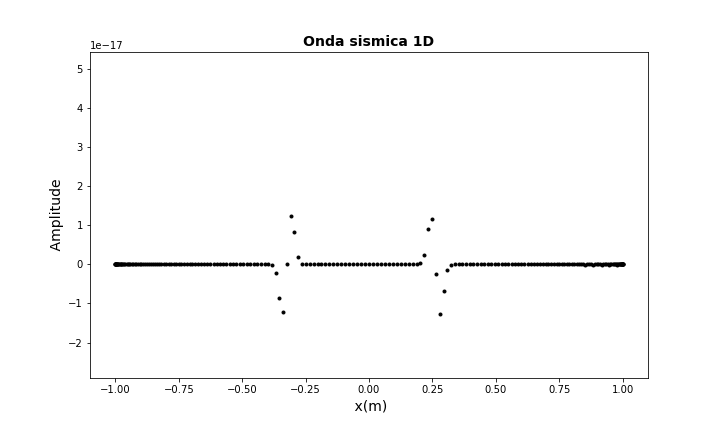

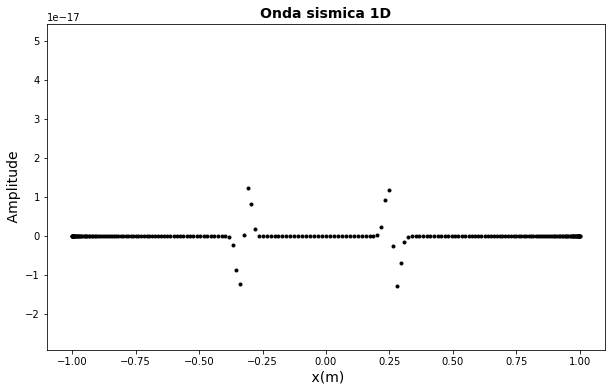

In [4]:
p = np.zeros(nx+1) 
pnew = np.zeros(nx+1)
pold = np.zeros(nx+1)
d2p  = np.zeros(nx+1) 


iplot = 20        # Snapshot frequency

plt.switch_backend("nbagg")

# Matriz diferencial
D,x = cheb(nx)
# Initializar plot
# ---------------------------------------------------------------
plt.figure(figsize=(10,6))
line = plt.plot(x, p, 'k.', lw=2)

plt.xlabel(' x(m)', size=14)
plt.ylabel(' Amplitude ', size=14)
plt.title('Onda sismica 1D', fontweight='bold', fontsize=14)

plt.ion()
plt.show()
# ---------------------------------------------------------------



# Extrapolação temporal
# ---------------------------------------------------------------
for it in range(nt):
    # Derivadas espaciais
    dp = np.dot(D, p.T)
    dp = mu/rho * dp
    dp = D @ dp
    
    # Extrapolação 
    pnew = 2*p - pold + np.transpose(dp) * dt**2
    
    # Termo fonte
    pnew = pnew + sg*src[it]*dt**2/rho
    
    
    pold, p = p, pnew
    p[0] = 0; p[nx] = 0 # Condições de fronteira Dirislach
    
    
    # Animação
    if not it % iplot: 
        for l in line:
            l.remove()
            del l               
            
        # -------------------------------------- 
        # Display lines
        line = plt.plot(x, p, 'k.', lw=1.5)
        plt.gcf().canvas.draw()

e) Simule a situação de um meio não homogéneo. Considere que as funções $\rho, \mu$ dependem de $x$, variando numa região estreita, de um valor $p_{\textrm{min}}=p_0$ a outro $p_{\textrm{min}}=p_0 + \Delta p \equiv p_1.$ Tome, por exemplo,:
$\rho(x) = (\rho_0 + \rho_1e^{ax})/(1 + e^{ax}),$
onde $a$ é uma constante  positiva, suficientemente grande para fazer que a variação ocorra num intervalo de $5\%$ do seu domínio.(Considere uma expressão semelhante para $\mu$.) Tome $\Delta \rho/ \rho= 0.50$ e $\Delta \mu/ \mu= 0.05.$

Como podemos observar os novos parametros vão resultar em diferentes velocidades de propagação ao longo de x (meio não homogênio). Este efeito pode ser visto na animação a seguir, onde as ondas se propagam mais rápid/devagar a depender da posição. 

In [5]:
r0 = 2500
dr0 = r0/2
a = 20
rhoo = np.array([(r0 + (r0+dr0)*np.exp(a*xx))/(1+np.exp(a*xx)) for xx in x])


mu=2.25*10**10
dmu = mu/20

muu = np.array([(mu + (mu+dmu)*np.exp(a*xx))/(1+np.exp(a*xx)) for xx in x])

In [6]:
src,sg, dxmax, nt, dt,x =  fonte(rhoo, muu,f0,nx,tmax)

<IPython.core.display.Javascript object>


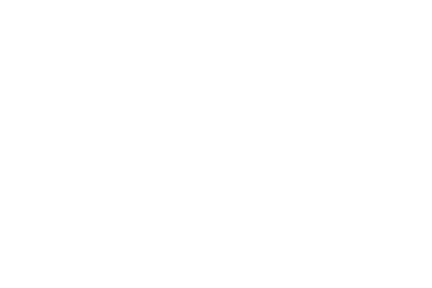

<IPython.core.display.Javascript object>


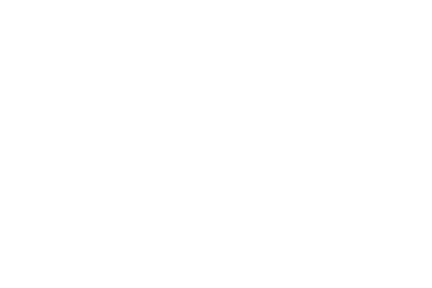

<IPython.core.display.Javascript object>


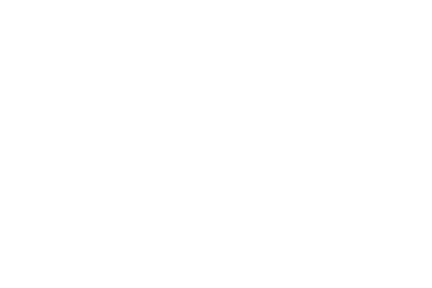

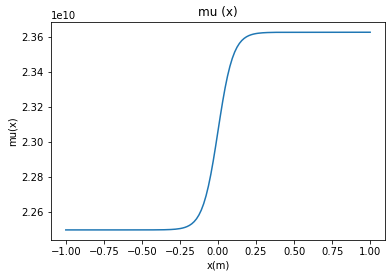

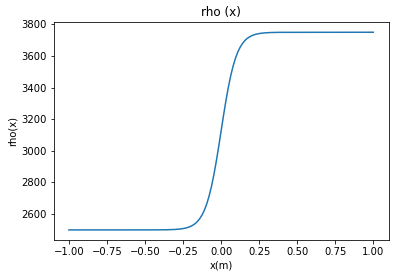

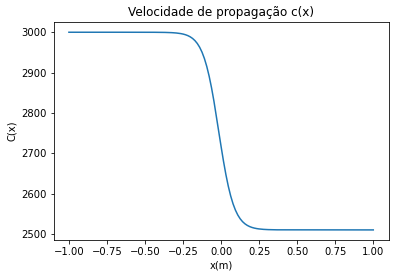

In [7]:
plt.figure(figsize=(6,4))
plt.plot(x, muu)
plt.title('mu (x)')
plt.xlabel('x(m)')
plt.ylabel('mu(x)')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(x, rhoo)
plt.title('rho (x)')
plt.xlabel('x(m)')
plt.ylabel('rho(x)')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(x, np.sqrt(muu/rhoo))
plt.title('Velocidade de propagação c(x)')
plt.xlabel('x(m)')
plt.ylabel('C(x)')
plt.show()

<IPython.core.display.Javascript object>


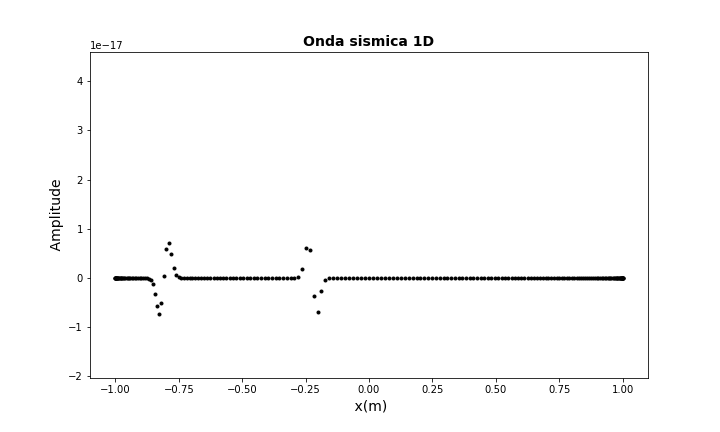

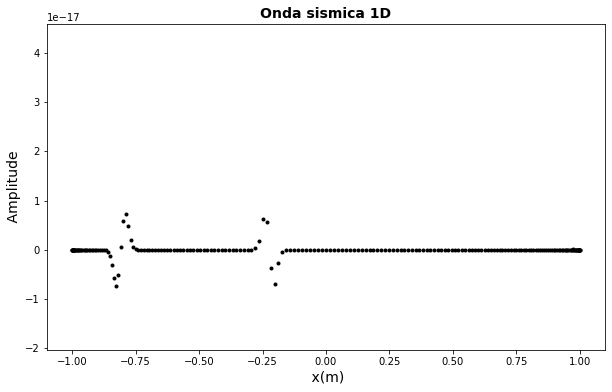

In [8]:
p = np.zeros(nx+1) 
pnew = np.zeros(nx+1)
pold = np.zeros(nx+1)
d2p  = np.zeros(nx+1) 


iplot = 20        # Snapshot frequency

plt.switch_backend("nbagg")

# Matriz diferencial
D,x = cheb(nx)
# Initializar plot
# ---------------------------------------------------------------
plt.figure(figsize=(10,6))
line = plt.plot(x, p, 'k.', lw=2)

plt.xlabel(' x(m)', size=14)
plt.ylabel(' Amplitude ', size=14)
plt.title('Onda sismica 1D', fontweight='bold', fontsize=14)

plt.ion()
plt.show()
# ---------------------------------------------------------------



# Extrapolação temporal
# ---------------------------------------------------------------
for it in range(nt):
    # Derivadas espaciais
    dp = np.dot(D, p.T)
    dp = muu/rhoo * dp
    dp = D @ dp
    
    # Extrapolação 
    pnew = 2*p - pold + np.transpose(dp) * dt**2
    
    # Termo fonte
    pnew = pnew + sg*src[it]*dt**2/rhoo
    
    
    pold, p = p, pnew
    p[0] = 0; p[nx] = 0 # Condições de fronteira Dirislach
    
    
    # Animação
    if not it % iplot: 
        for l in line:
            l.remove()
            del l               
            
        # -------------------------------------- 
        # Display lines
        line = plt.plot(x, p, 'k.', lw=1.5)
        plt.gcf().canvas.draw()

# Referencias

Códigos moodle: cheb.py, ricker.py

https://www.coursera.org/lecture/computers-waves-simulations/w5v8-chebyshev-method-1d-elastic-wave-equation-cFRqp